In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from Bio import SeqIO

# from deepcoil import DeepCoil
# from deepcoil.utils import plot_preds

import os
import re

from sklearn.cluster import KMeans

In [3]:
os.getcwd()

'/home/enno/uni/SS23/thesis/deepcoil'

## Extracting Stretches

In [4]:
input_file = '/ebio/abt1_share/prediction_hendecads/data/new_prot_fam_data/final_dataset.fasta'  # "/home/enno/uni/SS23/thesis/data/hendecads/sequences.fasta"

fasta_sequences = list(SeqIO.parse(open(input_file),'fasta'))
n_seq = len(fasta_sequences)

In [5]:
df = pd.DataFrame(columns=['id', 'seq', 'stretch_ix', 'stretch_seq'])

In [19]:
max_len = 1e6  # 1024


pattern = r'\[\[.*?\]\]'

for seq_ix, seq in enumerate(SeqIO.parse(open(input_file), 'fasta')):
    print(f"Processing sequence {seq_ix+1}/{n_seq}", end='\r')

    if len(seq.seq) > max_len:
        continue
    
    s = str(seq.seq)
    d = str(seq.description)
    
    stretches = eval(re.findall(pattern, d.split('|||')[-1])[0])

    
    for stretch in stretches:
        cc_ix = [x for stretch in stretches for x in np.arange(stretch[0], stretch[1]+1)]

        df.loc[len(df), ] = [seq.id, s, str(cc_ix), s[min(cc_ix):max(cc_ix)+1]]
        

df.head()


,id,seq,stretch_ix,stretch_seq
0,NaN,NaN,NaN,NaN
1,MCD6041253.1,Mrlvyvavaailcsfsttslagaektakragkfvektatragkfve...,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",rlvyvavaailcsfsttslagaektakragkfvektatragkfver...
2,MCD7737945.1,MQGRVFFREAAALILAAALSMAGLPASAAANSGIEAAALRTeeete...,"[41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 5...",eeetepstkeavqetavetdtgekpesgedgqeesaesteeeqeed...
3,MYF28459.1,Merlqtdllkeihalrgemhaefasvrqemhagfasirqemhaeta...,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",erlqtdllkeihalrgemhaefasvrqemhagfasirqemhaetas...
4,WP_168920948.1,MSDVFLTASYADREKVKTLGARWNPAEKRWYVPSGRDLSPFAAWLP...,"[437, 438, 439, 440, 441, 442, 443, 444, 445, ...",aqslvveikhaasqqlllarhvvparmaevtaegrqalrtakaqsq...


In [20]:
len(df)

48564

In [ ]:
out_file = '/home/enno/uni/SS23/thesis/code/ss_data/stretches.fasta'

with open(out_file, 'w') as f:
    for i, row in df.iterrows():

        print(f"Writing sequence {i+1}/{len(df)}", end='\r')

        f.write(f">{row['id']}_{row['stretch_ix']}\n{row['stretch_seq']}\n")

In [ ]:
inp = {str(entriy.id): str(entriy.seq) for entriy in SeqIO.parse(out_file, 'fasta')}
inp_ = {k: inp[k] for k in list(inp)[:1000]}

# DeepCoil

In [ ]:
dc = DeepCoil(use_gpu=False)
inp = {str(entry.id): str(entry.seq) for entry in SeqIO.parse(out_file, "fasta")}

for i in range(0, len(df), 1000):
    print(f"Processing sequences {i+1}-{min(i+1000, len(df))}", end='\r')

    tmp_keys = list(inp.keys())[i:i+1000]
    tmp_inp = {k: inp[k] for k in tmp_keys}

    preds = dc.predict(tmp_inp)
    averages = [np.mean(preds[key]['cc']) for key in preds.keys()]

    df.loc[i:i+1000-1, 'avg_cc'] = averages

    df.to_csv('/ebio/abt1_share/prediction_hendecads/data/stretches_w_values.csv', index=False)

In [4]:
df = pd.read_csv('/home/enno/uni/SS23/thesis/data/hendecads/stretches_w_values.csv')  # pd.read_csv('/ebio/abt1_share/prediction_hendecads/data/stretches_w_values.csv')

In [6]:
df.head()

,id,seq,stretch_ix,stretch_seq,avg_cc
0,MCD6041253.1,Mrlvyvavaailcsfsttslagaektakragkfvektatragkfve...,"[1, 71]",rlvyvavaailcsfsttslagaektakragkfvektatragkfver...,0.001041
1,MCD7737945.1,MQGRVFFREAAALILAAALSMAGLPASAAANSGIEAAALRTeeete...,"[41, 238]",eeetepstkeavqetavetdtgekpesgedgqeesaesteeeqeed...,0.000364
2,MYF28459.1,Merlqtdllkeihalrgemhaefasvrqemhagfasirqemhaeta...,"[1, 73]",erlqtdllkeihalrgemhaefasvrqemhagfasirqemhaetas...,0.001002
3,WP_168920948.1,MSDVFLTASYADREKVKTLGARWNPAEKRWYVPSGRDLSPFAAWLP...,"[437, 540]",aqslvveikhaasqqlllarhvvparmaevtaegrqalrtakaqsq...,0.000689
4,WP_026306873.1,MLLRRIARPLLSAAFIAEGIDILQNPGPLADRLSPALDFTRRRSQH...,"[172, 342]",slgwrgrraardakdhaealaataaaiaatarergtnlvdtarert...,0.000424


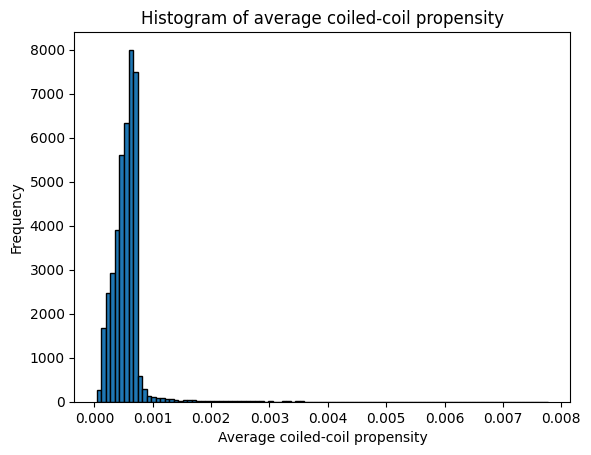

In [5]:
df.avg_cc.hist(bins=100, edgecolor='black', grid=False)  # ,log=True)
plt.title('Histogram of average coiled-coil propensity')
plt.xlabel('Average coiled-coil propensity')
plt.ylabel('Frequency')
plt.show()

# CLANS

### Visualize CC propensity for groups

In [3]:
clans_df = pd.DataFrame(columns=['group_id', 'type', 'hide', 'size', 'color', 'numbers'])

clans_data = "/home/enno/uni/SS23/thesis/data/hendecads/seqgroups.txt"

with open(clans_data, 'r') as file:
    data = file.read()

# Split the data by 'name='
group_data = re.split(r'name=', data)[1:]

for group_str in group_data:
    group_lines = group_str.strip().split('\n')
    
    group = {'group_id': group_lines[0], 
             'type': group_lines[1].split('=')[-1], 
             'size': group_lines[2].split('=')[-1],
             'hide': group_lines[3].split('=')[-1],
             'color': group_lines[4].split('=')[-1], 
             'numbers': list(map(int, group_lines[5].split('=')[-1].split(';')))}
    
    clans_df.loc[len(clans_df)] = group

In [12]:
prots = df.id.unique()
groups = clans_df.group_id.unique()

for group in groups:
    group_prots = clans_df[clans_df.group_id == group].numbers.values[0]
    
    group_df = df.iloc[group_prots]
    
    clans_df.loc[clans_df.group_id == group, 'mean_cc'] = group_df.avg_cc.mean()

Text(0, 0.5, 'Frequency')

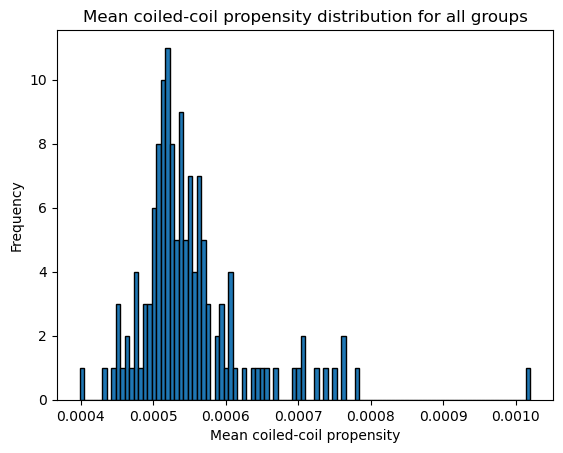

In [13]:
clans_df.mean_cc.hist(bins=100, edgecolor='black', grid=False)
plt.title('Mean coiled-coil propensity distribution for all groups')
plt.xlabel('Mean coiled-coil propensity')
plt.ylabel('Frequency')

### Visualize CC propensity in CLANS map

In [2]:
clans_data = '/home/enno/uni/SS23/thesis/data/hendecads/new_hendecads_1E-14.clans'  # "/ebio/abt1_share/prediction_hendecads/data/new_prot_fam_data/CLANS_cluster_map/new_hendecads_1E-14.clans"

with open(clans_data, 'r') as file:
    data = file.readlines()

data = [line.strip() for line in data]

In [3]:
first_pos = 73772
last_pos = 73772 + 36455

pos = [x.split() for x in data[first_pos:last_pos]]

pos_df = pd.DataFrame(pos, columns=['prot_id', 'x', 'y', '_'])

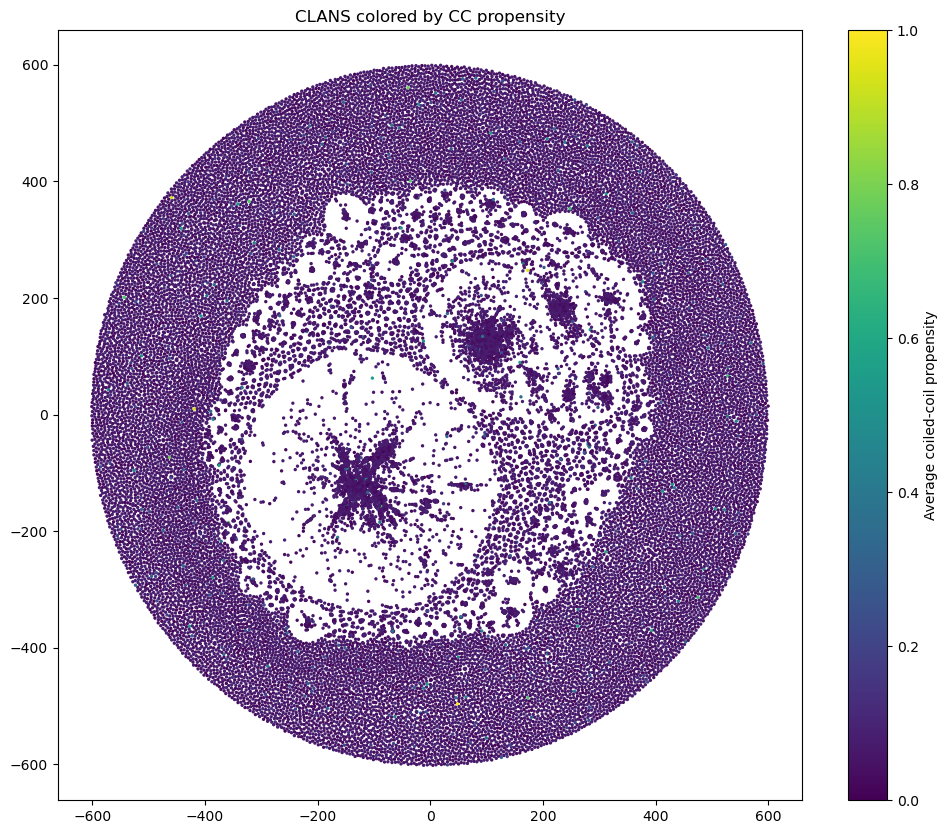

In [10]:
# Scatter plot of the proteins in the CLANS plot
pos_df.x = pos_df.x.astype(float)
pos_df.y = pos_df.y.astype(float)

# Use average CC values from df.avg_cc as color
pos_df['avg_cc'] = df.avg_cc
pos_df['avg_cc_norm'] = (pos_df.avg_cc - pos_df.avg_cc.min()) / (pos_df.avg_cc.max() - pos_df.avg_cc.min())

plt.figure(figsize=(12, 10))
plt.scatter(pos_df.x, pos_df.y, c=pos_df.avg_cc_norm, cmap='viridis', s=2)
plt.colorbar(label='Average coiled-coil propensity')
plt.title('CLANS colored by CC propensity')
plt.show()


# Clustering

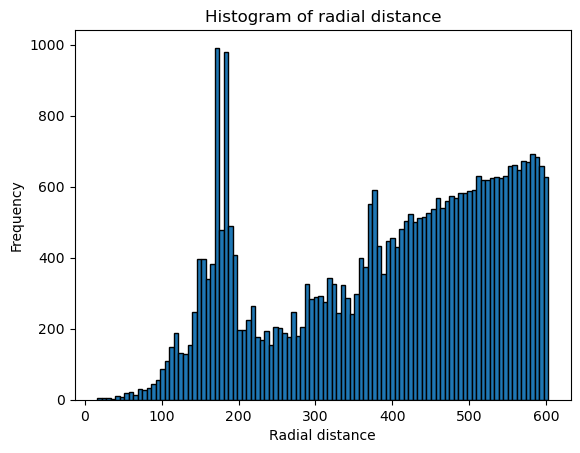

In [4]:
radial_distance = np.sqrt(pos_df['x'].astype(float)**2 + pos_df['y'].astype(float)**2)

plt.hist(radial_distance, bins=100, edgecolor='black')
plt.title('Histogram of radial distance')
plt.xlabel('Radial distance')
plt.ylabel('Frequency')
plt.show()

In [5]:
filtered_pos_df = pos_df[radial_distance <= 300]
filtered_pos_df.reset_index(drop=True, inplace=True)

In [6]:
plt.figure(figsize=(10, 10))
plt.scatter(pos_df.x, pos_df.y, s=5)

circle = plt.Circle((0, 0), 350, color='black', fill=False, lw=2)
plt.gca().add_artist(circle)

plt.title('CLANS colored by KMeans clusters')
plt.show()

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x72bf9eed5870>>
Traceback (most recent call last):
  File "/home/enno/anaconda3/envs/basenv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


## KMeans

In [14]:
# Optimize number of clusters
inertia = []

low = 2000
high = 5000
step = 500

for i in range(low, high, step):
    print(i)
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(filtered_pos_df[['x', 'y']])
    inertia.append(kmeans.inertia_)

2000
2500
3000
3500
4000
4500


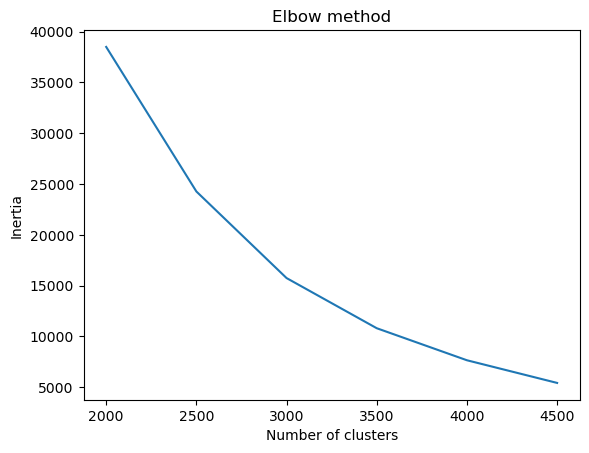

In [15]:
plt.plot(range(low, high, step), inertia)
# plt.axvline(x=6, color='red', linestyle='--')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()


/tmp/ipykernel_24729/1809658442.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_pos_df.loc[:, 'cluster'] = kmeans.labels_


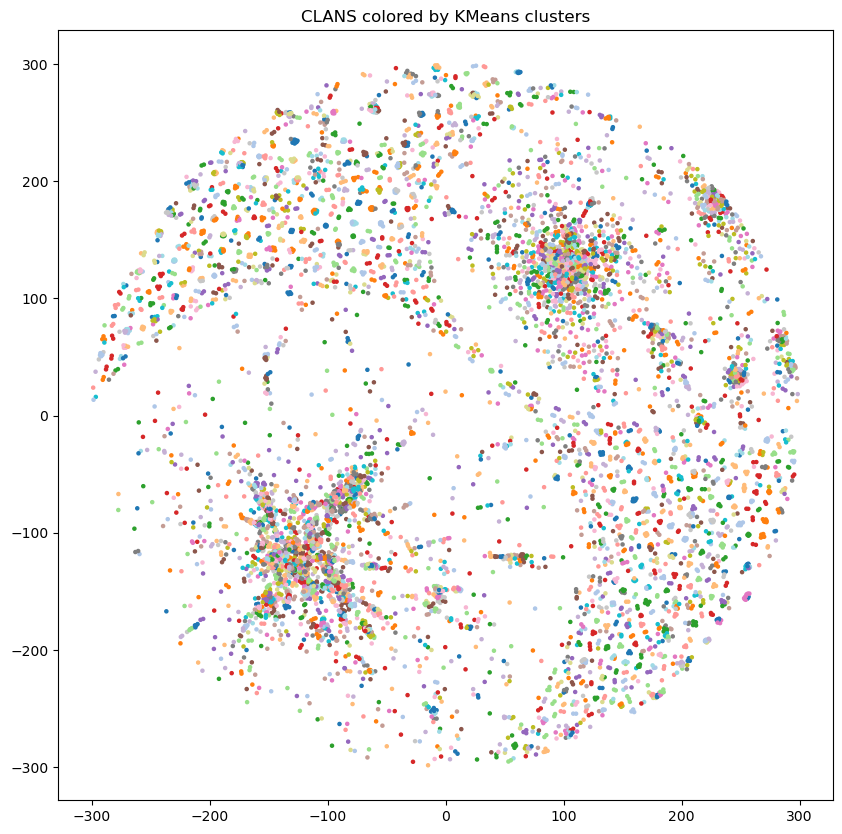

In [16]:
# KMeans clustering
n_clusters = 4000
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(filtered_pos_df[['x', 'y']])

filtered_pos_df.loc[:, 'cluster'] = kmeans.labels_

plt.figure(figsize=(10, 10))
plt.scatter(filtered_pos_df.x, filtered_pos_df.y, c=filtered_pos_df.cluster, cmap='tab20', s=5)
plt.title('CLANS colored by KMeans clusters')
plt.show()

## Louvain/Leiden

In [6]:
# Create distance matrix from x and y coordinates in DF
from scipy.spatial import distance_matrix
import networkx as nx

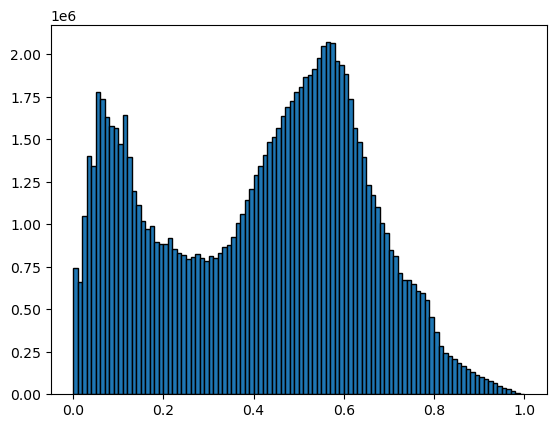

In [7]:
dm = distance_matrix(filtered_pos_df[['x', 'y']].astype(float), filtered_pos_df[['x', 'y']].astype(float))
norm_dm = dm / dm.max()

plt.hist(norm_dm.flatten(), bins=100, edgecolor='black')
plt.show()

In [8]:
knn = 1000
knn_dm = np.zeros_like(norm_dm)

for i in range(len(norm_dm)):
    knn_ix = np.argsort(norm_dm[i])[1:knn+1]
    knn_dm[i, knn_ix] = norm_dm[i, knn_ix]

In [9]:
adj_matrix = np.zeros_like(norm_dm)

for i in range(len(norm_dm)):
    closest = np.argsort(norm_dm[i])[1:knn+1]
    adj_matrix[i, closest] = 1

In [10]:
G_dm = nx.from_numpy_array(knn_dm)
G_adj = nx.from_numpy_array(adj_matrix)

In [11]:
pos_dm = nx.fruchterman_reingold_layout(G_dm)
pos_adj = nx.fruchterman_reingold_layout(G_adj)

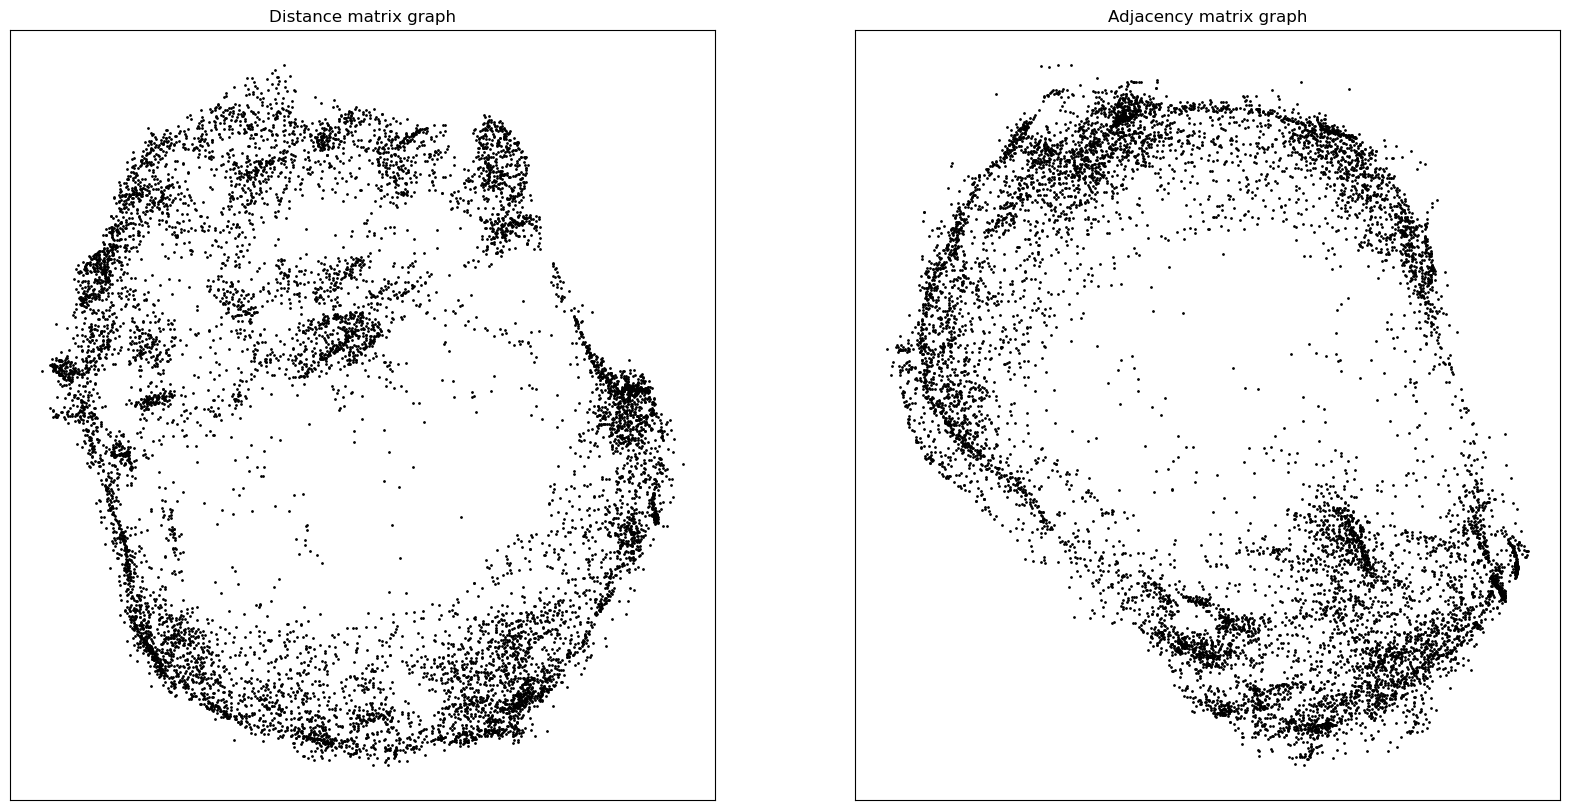

In [12]:
# Draw graphs side by side
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

nx.draw_networkx_nodes(G_dm, pos_dm, ax=ax[0], node_size=1, node_color='black',)
nx.draw_networkx_nodes(G_adj, pos_adj, ax=ax[1], node_size=1, node_color='black')

ax[0].set_title('Distance matrix graph')
ax[1].set_title('Adjacency matrix graph')

plt.show()

In [13]:
partition_dm = nx.community.louvain_communities(G_dm, seed=42)

In [28]:
for c in partition_dm:
    print(c)

{4097, 4098, 3, 8197, 8202, 11, 12, 4110, 4111, 17, 4113, 4117, 4119, 8218, 27, 8220, 4125, 8222, 34, 4134, 8231, 42, 4143, 8239, 49, 8245, 8246, 4156, 8260, 8269, 83, 90, 8285, 8286, 93, 96, 8288, 8290, 106, 4206, 115, 116, 118, 8314, 8315, 4220, 123, 8318, 129, 8323, 8327, 8329, 138, 4233, 4243, 148, 149, 150, 4245, 8344, 8345, 152, 8349, 4258, 8357, 8358, 167, 4268, 8369, 183, 4282, 4283, 4284, 188, 8383, 8386, 4292, 4293, 4294, 202, 203, 8396, 8398, 8400, 208, 4306, 8401, 8405, 216, 4314, 220, 225, 8420, 8428, 8430, 239, 8432, 240, 4335, 243, 244, 8437, 8438, 8439, 4340, 4341, 4346, 8442, 8444, 250, 4347, 4351, 4353, 8449, 8451, 4358, 4359, 264, 8459, 268, 8462, 276, 279, 8474, 4378, 4380, 282, 286, 291, 8484, 293, 8483, 4391, 4388, 4393, 8489, 298, 4403, 8500, 4404, 8507, 4413, 318, 319, 322, 8516, 4422, 327, 4427, 4428, 8525, 4434, 8531, 4442, 346, 8545, 4449, 4452, 8550, 360, 8553, 8554, 8560, 369, 4466, 4465, 8564, 8568, 377, 4476, 4483, 387, 8581, 391, 392, 8587, 397, 4495, 44

In [29]:
for i, cluster in enumerate(partition_dm):
    filtered_pos_df.loc[filtered_pos_df.index[list(cluster)], 'louvain_cluster'] = i

/tmp/ipykernel_147310/315039741.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_pos_df.loc[filtered_pos_df.index[list(cluster)], 'louvain_cluster'] = i


In [30]:
# Draw graph with communities
plt.figure(figsize=(10, 10))

nx.draw(G_dm, pos_dm, node_size=1, node_color=filtered_pos_df.louvain_cluster, cmap='tab20')

plt.title('Communities from distance matrix graph')
plt.show()

: 